In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.style as style
import json
%matplotlib inline

In [89]:
class EloCalculator:
    def __init__(self, events_path, batter_path, pitcher_path, elo_path, starting_elo=1500):
        self.batters = []
        self.pitchers = []
        
        self.dfEvents = pd.read_csv(events_path)
        self.dfBatter = pd.read_csv(batter_path)
        self.dfPitcher = pd.read_csv(pitcher_path)
        
        self.elo_table = pd.read_csv(elo_path)
        self.elo_dict = dict(zip(self.elo_table['player_id'], self.elo_table['elo_rating']))
        
        player_total_change = [0] * len(self.elo_table['player_id'])
        self.change_dict = dict(zip(self.elo_table['player_id'], player_total_change))
        
        self.starting_elo = starting_elo
        

        # Pandas .apply() is the worst
        for _, row in self.dfBatter.iterrows():
            self.add_player(row, self.batters)
            
        for _, row in self.dfPitcher.iterrows():
            self.add_player(row, self.pitchers)
        
    def add_player(self, row, players_dict):
        players_dict.append(self.get_player_object(
            row['player_id'], row['nameFirst'], row['nameLast'], row['teamID']))
        
    def get_player_object(self, player_id, first_name, last_name, team):
        player = {
            'player_id': player_id,
            'name': first_name + ' ' + last_name,
            'team': team,
            'elo': [],
            'norm_elo': []
        }
        return player
        
    def calc_season_elo(self, k=2):
        self.k = k
        num_rows = self.dfEvents.shape[0]
        prev_prop = 0
        i = 0
        
        for _, row in self.dfEvents.iterrows():
            curr_prop = i/num_rows
            if (curr_prop - prev_prop) > 1/10:
                self.save_snapshot()
                prev_prop = curr_prop

            self.update_elo(row['bat_id'], row['pit_id'], row['batter_score'], row['pitcher_score'])
            i += 1
        self.save_snapshot()
            
    def save_snapshot(self):
        bat_elos = []
        pit_elos = []
        bat_max = 0
        pit_max = 0
        
        # Welcome to hell
        for player_object in self.batters:
            current_elo = self.elo_dict[player_object['player_id']]
            if self.change_dict[player_object['player_id']] >= 20:
                if current_elo > bat_max:
                    bat_max = current_elo
                bat_elos.append(current_elo)

        for player_object in self.pitchers:
            current_elo = self.elo_dict[player_object['player_id']]
            if self.change_dict[player_object['player_id']] >= 20:
                if current_elo > pit_max:
                    pit_max = current_elo
                pit_elos.append(current_elo)
        
        bat_mean = np.mean(bat_elos)
        pit_mean = np.mean(pit_elos)

        for player_object in self.batters:
            current_elo = self.elo_dict[player_object['player_id']]
            if self.change_dict[player_object['player_id']] < 20:
                player_object['elo'].append(None)
                player_object['norm_elo'].append(None)
            else:
                player_object['elo'].append(current_elo)
                player_object['norm_elo'].append((current_elo-bat_mean)/bat_max)
            
        for player_object in self.pitchers:
            current_elo = self.elo_dict[player_object['player_id']]
            if self.change_dict[player_object['player_id']] < 20:
                player_object['elo'].append(None)
                player_object['norm_elo'].append(None)
            else:
                player_object['elo'].append(current_elo)
                player_object['norm_elo'].append((current_elo-bat_mean)/bat_max)

    def update_elo(self, bat_id, pit_id, bat_score, pit_score):
        bat_exp, pit_exp = self.get_expected(bat_id, pit_id)
        bat_curr = self.elo_dict[bat_id]
        pit_curr = self.elo_dict[pit_id]

        bat_new = self.calc_new(bat_curr, bat_score, bat_exp)
        pit_new = self.calc_new(pit_curr, pit_score, pit_exp)

        self.elo_dict[bat_id] = bat_new
        self.elo_dict[pit_id] = pit_new
        
        self.change_dict[bat_id] += abs(bat_new - bat_curr)
        self.change_dict[pit_id] += abs(pit_new - pit_curr)

    def get_expected(self, bat_id, pit_id):
        bat_diff = self.elo_dict[bat_id] - self.elo_dict[pit_id]
        pit_diff = -bat_diff
        return self.calc_expected(bat_diff), self.calc_expected(pit_diff)

    def calc_expected(self, diff):
        return 1/(1+(np.power(10, (diff/400))))

    def calc_new(self, curr, score, exp):
        return curr+(self.k*(score-exp))    
    
    def get_batters_df(self):
        return pd.DataFrame(self.batters)
    
    def get_pitchers_df(self):
        return pd.DataFrame(self.pitchers)

In [90]:
elo = EloCalculator('data/events_elo.csv', 'data/batters.csv', 'data/pitchers.csv', 'data/elo.csv')
elo.calc_season_elo()

In [91]:
batter_json = {'players': elo.batters}
pitcher_json = {'players': elo.pitchers}


with open('output/batters.json', 'w') as outfile:
    json.dump(batter_json, outfile)
    
with open('output/pitchers.json', 'w') as outfile:
    json.dump(pitcher_json, outfile)

In [92]:
dfBat = elo.get_batters_df()
dfPit = elo.get_pitchers_df()
dfBat.head()

,elo,name,norm_elo,player_id,team
0,"[None, 1455.1150548444252, 1424.8031070295694,...",Miguel Cabrera,"[None, 0.00729968550822418, 0.0066167047508666...",cabrm001,DET
1,"[1352.2658567796702, 1341.8535699909933, 1319....",Paul Goldschmidt,"[-0.07726405181827208, -0.0681544022285955, -0...",goldp001,ARI
2,"[1398.430643895625, 1368.2694785055824, 1339.1...",Mike Trout,"[-0.046509361449286434, -0.05055629037895017, ...",troum001,LAA
3,"[None, 1421.7778804437407, 1412.2989523890399,...",Robinson Cano,"[None, -0.01490933007533486, -0.00175100809876...",canor001,NYA
4,"[1491.8666215504086, 1491.8666215504086, 1186....",Joey Votto,"[0.015737098279392753, 0.03178334773715726, -0...",vottj001,CIN


In [93]:
style.use('fivethirtyeight')
colors = ["#4F78A6", "#F18D2F", "#E05759", "#76B6B1", "#59A050", "#ECC84A", "#AE79A0"]
best_batters = ["Mike Trout", "Andrew McCutchen", "Miguel Cabrera", "Josh Donaldson", "Carlos Gomez"]
best_pitchers = ['Clayton Kershaw', 'Max Scherzer', 'Cliff Lee', 'Felix Hernandez', 'Matt Harvey']

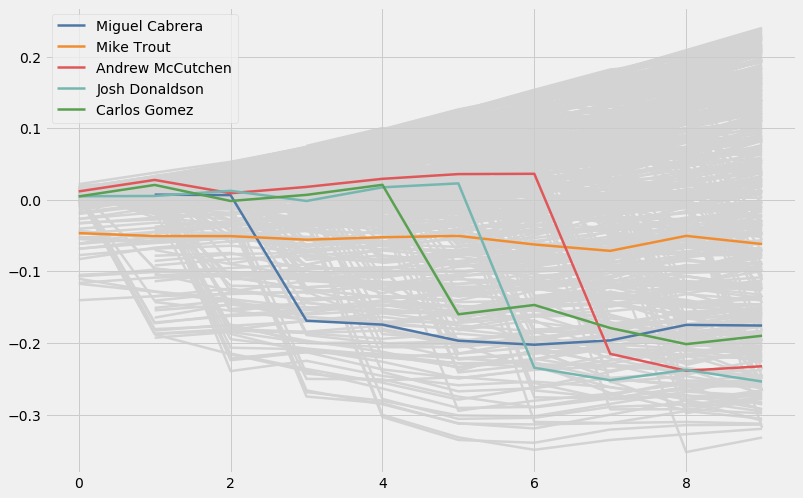

In [94]:
fig = plt.figure(1, figsize=(12,8))
ax1  = fig.add_subplot(111)
c = 0

for _, row in dfBat.iterrows():
    color = 'lightgrey'
    zorder = -1
    label = None
    if row['name'] in best_batters:
        color = colors[c]
        c += 1
        zorder = 10
        label = row['name']
    ax1.plot(row['norm_elo'], linewidth=2.5, color=color, zorder=zorder, label=label)
    ax1.legend()

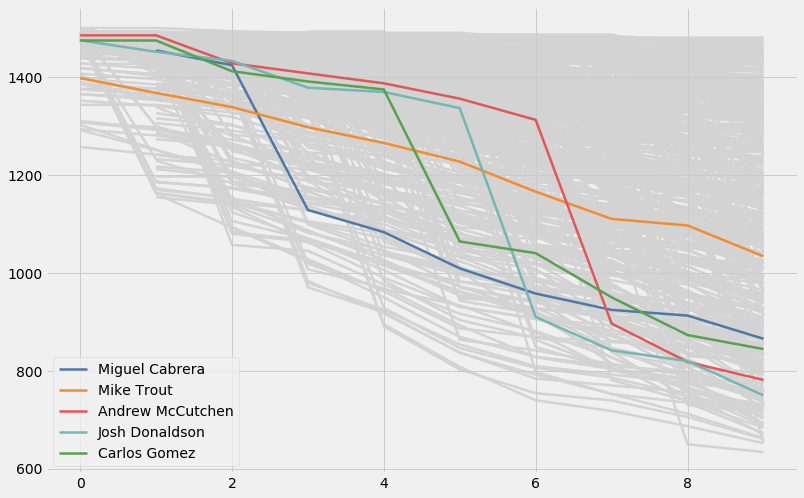

In [95]:
fig = plt.figure(1, figsize=(12,8))
ax1  = fig.add_subplot(111)
c = 0

for _, row in dfBat.iterrows():
    color = 'lightgrey'
    zorder = -1
    label = None
    if row['name'] in best_batters:
        color = colors[c]
        c += 1
        zorder = 10
        label = row['name']
    ax1.plot(row['elo'], linewidth=2.5, color=color, zorder=zorder, label=label)
    
ax1.legend()

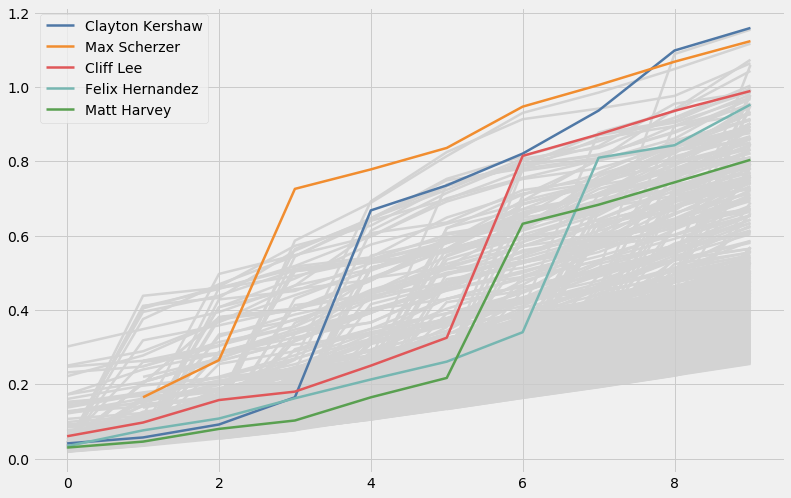

In [96]:
fig = plt.figure(1, figsize=(12,8))
ax1  = fig.add_subplot(111)
c = 0

for _, row in dfPit.iterrows():
    color = 'lightgrey'
    zorder = -1
    label = None
    if row['name'] in best_pitchers:
        color = colors[c]
        c += 1
        zorder = 10
        label = row['name']
    ax1.plot(row['norm_elo'], linewidth=2.5, color=color, zorder=zorder, label=label)
    ax1.legend()

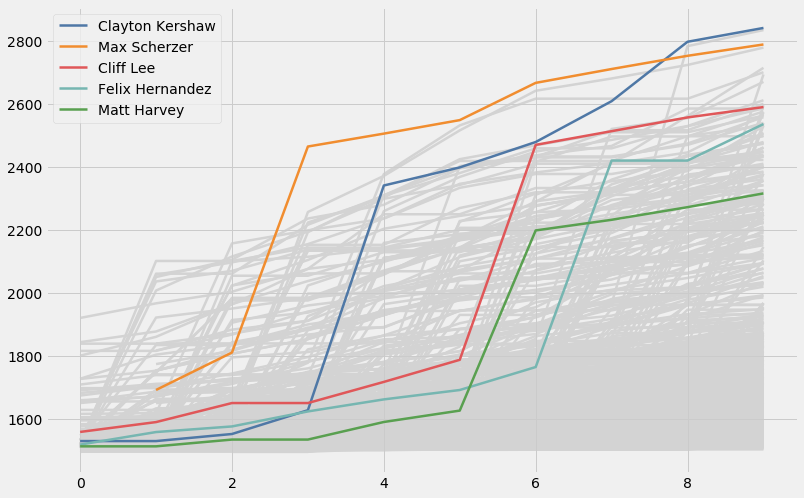

In [97]:
fig = plt.figure(1, figsize=(12,8))
ax1  = fig.add_subplot(111)
c = 0

for _, row in dfPit.iterrows():
    color = 'lightgrey'
    zorder = -1
    label = None
    if row['name'] in best_pitchers:
        color = colors[c]
        c += 1
        zorder = 10
        label = row['name']
    ax1.plot(row['elo'], linewidth=2.5, color=color, zorder=zorder, label=label)
    ax1.legend()